In [1]:
from transformers import GPT2LMHeadModel

In [2]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2")
sd_hf = model_hf.state_dict()

for k, v in sd_hf.items():
    print(k, v.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

In [3]:
sd_hf["transformer.h.0.mlp.c_fc.weight"].view(-1)[:20]

tensor([ 0.0942,  0.0982, -0.0321,  0.0671, -0.1154,  0.0026,  0.0048, -0.1350,
        -0.0204, -0.0472,  0.1527,  0.0976, -0.0455,  0.0084, -0.0444,  0.0727,
         0.1614, -0.0444, -0.0066,  0.0341])

Using matplotlib backend: module://matplotlib_inline.backend_inline


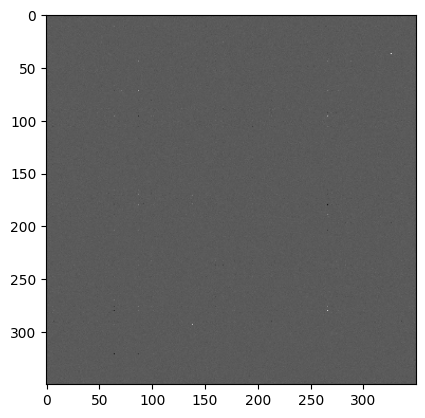

In [4]:
import matplotlib.pyplot as plt
%matplotlib

plt.imshow(sd_hf["transformer.h.0.mlp.c_proj.weight"][:350,:350], cmap="gray")

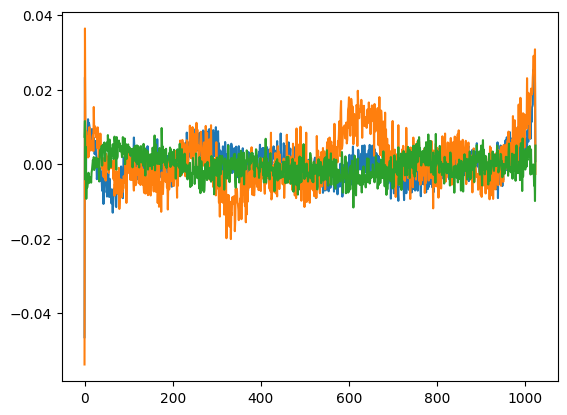

In [5]:
plt.plot(sd_hf["transformer.wpe.weight"][:,150])
plt.plot(sd_hf["transformer.wpe.weight"][:,200])
plt.plot(sd_hf["transformer.wpe.weight"][:,700])

In [13]:
from pathlib import Path

dataset_dir = Path('data')
dataset_file = dataset_dir / 'tiny_shakespeare.txt'

dataset_dir.mkdir(exist_ok=True)

if not dataset_file.exists():
    import urllib.request
    print("Downloading tiny Shakespeare dataset...")
    url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
    urllib.request.urlretrieve(url, dataset_file)
    print(f"Dataset saved to {dataset_file}")

with open(dataset_file, 'r', encoding='utf-8') as f:
    text = f.read()

print(f"Dataset length: {len(text)} characters")

print("\nSample of data:")
print(text[:100])

Dataset length: 1115394 characters

Sample of data:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [14]:
import tiktoken
enc = tiktoken.get_encoding("gpt2")
tokens = enc.encode(text)
print(f"Number of tokens: {len(tokens)}")
print(f"Compression ratio: {len(text)/len(tokens):.2f}")

Number of tokens: 338025
Compression ratio: 3.30


In [15]:
import torch
buf = torch.tensor(tokens[:24+1])
x = buf[:-1].view(4, -1)
y = buf[1:].view(4, -1)
print(x)
print(y)

tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])
tensor([[22307,    25,   198,  8421,   356,  5120],
        [  597,  2252,    11,  3285,   502,  2740],
        [   13,   198,   198,  3237,    25,   198],
        [ 5248,   461,    11,  2740,    13,   198]])


In [1]:
import torch
import torch.nn as nn

class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim=384, hidden_dim=512, num_layers=2, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x, hidden=None):
        # x shape: (batch_size, seq_len)
        embeds = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        rnn_out, hidden = self.rnn(embeds, hidden)  # (batch_size, seq_len, hidden_dim)
        output = self.fc(rnn_out)  # (batch_size, seq_len, vocab_size)
        return output, hidden
    
    def init_hidden(self, batch_size, device):
        # Initialize hidden state and cell state
        return (torch.zeros(self.rnn.num_layers, batch_size, self.rnn.hidden_size).to(device),
                torch.zeros(self.rnn.num_layers, batch_size, self.rnn.hidden_size).to(device))

vocab_size = 50257  
model = SimpleRNN(vocab_size)
print(model)

batch_size = 4
seq_len = 6
x = torch.randint(0, vocab_size, (batch_size, seq_len))
output, _ = model(x)
print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")

SimpleRNN(
  (embedding): Embedding(50257, 384)
  (rnn): LSTM(384, 512, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=512, out_features=50257, bias=True)
)
Input shape: torch.Size([4, 6])
Output shape: torch.Size([4, 6, 50257])


In [8]:
for n,p in model.named_parameters():
    print(n, p.shape)

embedding.weight torch.Size([50257, 384])
rnn.weight_ih_l0 torch.Size([2048, 384])
rnn.weight_hh_l0 torch.Size([2048, 512])
rnn.bias_ih_l0 torch.Size([2048])
rnn.bias_hh_l0 torch.Size([2048])
rnn.weight_ih_l1 torch.Size([2048, 512])
rnn.weight_hh_l1 torch.Size([2048, 512])
rnn.bias_ih_l1 torch.Size([2048])
rnn.bias_hh_l1 torch.Size([2048])
fc.weight torch.Size([50257, 512])
fc.bias torch.Size([50257])
